In [72]:
#Import the necessary packages.
import os
import pandas as pd
from sklearn.feature_extraction.text import ENGLISH_STOP_WORDS, CountVectorizer
from sklearn.model_selection import train_test_split
import numpy as np
import re
from scipy.stats import norm, mode
from scipy.special import psi, gammaln, digamma
import scipy.special as sp
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style("whitegrid")
sns.set_context("talk", font_scale=1.2)  # adjust font_scale as needed
current_palette = sns.color_palette("pastel")  # There are many other palettes like "deep", "muted", etc.


In [45]:
class LDA_CAVI:
    """
    This class implements Coordinate-Ascent Variational Inference (CAVI) for the Latent Dirichlet Allocation (LDA) model.
    LDA is a generative probabilistic model for collections of discrete data such as text corpora.
    CAVI is an optimization approach to find an approximation to the posterior distribution.
    """

    def __init__(self, X, K=2, alpha=1, eta=1, test_size=0.2, random_state=42, iter_for_theta=1000):
        """
        Initialize the LDA_CAVI object with data and parameters for the LDA model.
        
        Parameters:
        X (DataFrame): A DataFrame representing the document-term matrix for the collection.
        K (int): The number of topics to be discovered in the document collection.
        alpha (float): The hyperparameter for the Dirichlet prior on the topic distribution per document.
        eta (float): The hyperparameter for the Dirichlet prior on the word distribution per topic.
        test_size (float): The proportion of the dataset to include in the test split.
        random_state (int): A seed value to ensure reproducibility of the random processes.
        iter_for_theta (int): The number of iterations for updating theta, the topic distribution per document.
        """
        self.X = X  # The entire document-term matrix
        self.random_state = random_state  # Seed for the random number generator
        # Split the document-term matrix into training and testing sets
        self.X_train, self.X_test = train_test_split(X, test_size=test_size, random_state=self.random_state)
        self.K = K  # The number of topics
        self.alpha = alpha  # Hyperparameter for the Dirichlet prior on the topic distribution
        self.eta = eta  # Hyperparameter for the Dirichlet prior on the word distribution
        self.N, self.V = self.X_train.shape  # The number of documents (N) and vocabulary size (V)
        self.iter_for_theta = iter_for_theta  # Number of iterations for updating theta
        # Generate dataframes for observed and new words in the test documents
        self.test_obs_df, self.test_new_df = self.generate_obs_new_df(self.X_test)

    def _init(self):
        """Initialize variational parameters for the LDA CAVI algorithm."""
        # Initialize lambda (topic-word distribution) variational parameters with small values
        self.lambda_kv = self.lambda_init(method="small_values")
        # Initialize gamma (document-topic distribution) variational parameters
        self.gamma_ik = self.gamma_init()
        # Initialize phi (word-topic assignment probabilities) variational parameters
        self.phi_ijk = self.phi_init()

    def generate_obs_new_df(self, df):
        """
        Splits the columns of the input dataframe into two halves to create two new dataframes.
        
        Parameters:
        df (DataFrame): The dataframe to be split.
        
        Returns:
        tuple: A tuple containing two dataframes, one with the first half of the columns (test_obs_df)
            and one with the second half (test_new_df).
        """
        # Shuffle the columns of the dataframe using a fixed random state for reproducibility
        shuffled_columns = df.columns.to_list()
        shuffled_columns = pd.Series(shuffled_columns).sample(frac=1, random_state=self.random_state).tolist()
        
        # Find the midpoint of the list of shuffled columns
        midpoint = len(shuffled_columns) // 2
        # Split the columns into two halves
        first_half_columns = shuffled_columns[:midpoint]
        second_half_columns = shuffled_columns[midpoint:]
        
        # Create two new dataframes, each with one half of the columns
        test_new_df = df[first_half_columns]
        test_obs_df = df[second_half_columns]
        
        # Return the two dataframes
        return test_obs_df, test_new_df

    def lambda_init(self, method="uniform"):
        """
        Initialize the lambda parameter with a specified method.
        
        Parameters:
        method (str): The method to use for initialization. Options are "uniform", "small_values", "dirichlet",
                    and "uniform_noisy".
        
        Returns:
        numpy.ndarray: The initialized lambda matrix of size K x V (number of topics x vocabulary size).
        """
        if method == "uniform":
            # Initialize lambda with ones
            lambda_kv = np.ones((self.K, self.V))
        elif method == "small_values":
            # Initialize lambda with small random values
            lambda_kv = np.random.uniform(0.001, 0.01, size=(self.K, self.V))
        elif method == "dirichlet":
            # Initialize lambda using a Dirichlet distribution
            lambda_kv = np.random.dirichlet([self.alpha]*self.V, size=self.K)
        elif method == "uniform_noisy":
            # Initialize lambda with ones and add small random noise
            noise = np.random.uniform(0.001, 0.01, size=(self.K, self.V))
            lambda_kv = np.ones((self.K, self.V)) + noise
        
        # Return the initialized lambda
        return lambda_kv

    
    def gamma_init(self):
        """
        Initialize gamma, which represents the document-topic distribution for each document.
        
        Returns:
        numpy.ndarray: An initialized gamma matrix of size N x K, where N is the number of documents
                    and K is the number of topics, filled with ones.
        """
        # Initialize gamma with ones, indicating an equal initial distribution of topics per document
        return np.ones((self.N, self.K))

    def phi_init(self):
        """
        Initialize phi, which represents the word-topic assignment probabilities for each word in each document.
        
        Returns:
        numpy.ndarray: An initialized phi tensor of size N x V x K, where N is the number of documents,
                    V is the vocabulary size, and K is the number of topics, with uniform probabilities.
        """
        # Initialize an empty 3D array for phi with dimensions for documents (N), words (V), and topics (K)
        phi_ijk = np.empty((self.N, self.V, self.K))
        for i in range(self.N):
            # For each document, set an equal probability for each topic for every word
            phi_ijk[i, :, :] = 1.0 / self.K
        # Return the initialized phi
        return phi_ijk

    def get_elbo(self):
        """
        Calculate the Evidence Lower Bound (ELBO) of the variational objective.
        
        Returns:
        float: The value of the ELBO, which is a scalar representing the lower bound on the log likelihood
            of the observed data under the variational distribution.
        """
        # Calculate the ELBO by summing the expected log joint probability and the negative entropy
        return self.expected_log_joint() + self.negative_entropy()

    def beta_hat(self):
        """
        Compute the expected value of beta (word-topic distribution) under the variational distribution.
        
        Returns:
        numpy.ndarray: A matrix representing the normalized expected word-topic distributions, 
                    with size K x V (number of topics x vocabulary size).
        """
        # Normalize lambda_kv over the vocabulary to obtain the expected beta distribution for each topic
        expected_beta = self.lambda_kv / self.lambda_kv.sum(axis=1, keepdims=True)
        return expected_beta

    def theta_i_hat(self):
        """
        Compute the estimated topic proportions for each document in the test set.
        
        Returns:
        numpy.ndarray: An array where each row corresponds to the estimated topic proportions for a document.
        """
        # Initialize an empty list to store the estimated topic proportions
        theta_hat = []
        # Iterate over each document in the observed test set
        for index, new_doc in self.test_obs_df.iterrows():
            # Compute the topic proportions for the new document
            topic_proportions = self.compute_topic_proportions_for_new_doc(new_doc)
            theta_hat.append(topic_proportions)
        # Convert the list of topic proportions to a numpy array and return
        return np.array(theta_hat)

    def compute_n_k(self, k):
        """
        Compute the expected count of all words associated with topic k across all documents.
        
        Parameters:
        k (int): The index of the topic.
        
        Returns:
        numpy.ndarray: The expected count vector n_k for all words in the vocabulary.
        """
        # Initialize the count array for all words
        n_k = np.zeros(self.V)  # Assuming self.V is the size of the vocabulary
        # Iterate over each word in the vocabulary
        for v in range(self.V):
            n_k[v] = self.compute_n_kv(v, k)
        # Return the computed count array
        return n_k

    def compute_n_kv(self, v, k):
        """
        Compute the expected count of word v associated with topic k across all documents.
        
        Parameters:
        v (int): The index of the word in the vocabulary.
        k (int): The index of the topic.
        
        Returns:
        float: The expected count n_kv.
        """
        # Initialize the count to zero
        n_kv = 0
        # Iterate over each document
        for i in range(self.N):
            # Get the count of word v in document i
            x_v = self.X_train.iloc[i, v]
            # Get the variational parameter phi for word v and topic k in document i
            z_k = self.phi_ijk[i][v, k]
            # Update the count with the product of x_v and z_k
            n_kv += x_v * z_k
        # Return the computed count
        return n_kv
    
    def beta_k(self):
        """
        Sample from the conditional distribution of beta, the word-topic distribution, for each topic k.

        Returns:
        numpy.ndarray: A matrix representing the conditional word-topic distributions sampled from a Dirichlet distribution,
                    with size K x V (number of topics x vocabulary size).
        """
        # Initialize an empty matrix to store the conditional distributions for each topic
        cond_beta_k = np.empty((self.K, self.V))
        # Iterate over each topic k
        for k in range(self.K):
            # Compute the posterior parameters for the Dirichlet distribution of topic k
            post_params = [self.eta + n for n in self.compute_n_k(k)]
            # Sample the conditional beta distribution for topic k from a Dirichlet distribution
            cond_beta_k[k, :] = np.random.dirichlet(alpha=post_params)
        # Return the matrix of conditional distributions
        return cond_beta_k

    def compute_m_ik(self, i, k):
        """
        Compute the expected count of topic k in document i.

        Parameters:
        i (int): The index of the document.
        k (int): The index of the topic.
        
        Returns:
        float: The expected count m_ik of topic k in document i.
        """
        # Sum over all words in document i for topic k to compute the expected count
        m_ik = np.sum(self.phi_ijk[i][:, k])
        # Return the computed count
        return m_ik

    def compute_m_i(self, i):
        """
        Compute the expected topic counts for document i across all topics.

        Parameters:
        i (int): The index of the document.
        
        Returns:
        numpy.ndarray: An array of expected topic counts for document i, with size K (number of topics).
        """
        # Initialize an array to store the expected counts for each topic
        m_i = np.zeros(self.K)
        # Iterate over each topic k
        for k in range(self.K):
            # Compute the expected count of topic k in document i
            m_i[k] = self.compute_m_ik(i, k)
        # Return the array of expected counts
        return m_i
    
    def theta_i(self):
        """
        Sample from the conditional distribution of theta, the document-topic distribution, for each document i.

        Returns:
        numpy.ndarray: A matrix representing the conditional document-topic distributions sampled from a Dirichlet distribution,
                    with size N x K (number of documents x number of topics).
        """
        # Initialize an empty matrix to store the conditional distributions for each document
        cond_theta_i = np.empty((self.N, self.K))
        # Iterate over each document i
        for i in range(self.N):
            # Compute the posterior parameters for the Dirichlet distribution of document i
            post_params = [self.alpha + n for n in self.compute_m_i(i)]
            # Sample the conditional theta distribution for document i from a Dirichlet distribution
            cond_theta_i[i, :] = np.random.dirichlet(alpha=post_params)
        # Return the matrix of conditional distributions
        return cond_theta_i

    def compute_topic_proportions_for_new_doc(self, new_doc):
        """
        Compute the topic proportions for a new document based on the trained model parameters.

        Parameters:
        new_doc (Series): A pandas Series representing the word counts in the new document.

        Returns:
        numpy.ndarray: An array representing the topic proportions for the new document.
        """
        # Initialize gamma for the new document with the Dirichlet prior multiplied by the number of topics
        gamma_new = np.ones(self.K) * self.alpha
        
        # Find the words in the new document that are also in the trained vocabulary
        observed_words = new_doc.index.intersection(self.X_train.columns)
        # Get the indices of the observed words in the vocabulary
        observed_word_indices = [self.X_train.columns.get_loc(word) for word in observed_words]
        
        # Get the word counts for the observed words in the new document
        observed_counts = new_doc[observed_words].values
        
        # Initialize phi for the observed words in the new document with uniform distribution over topics
        phi_new = np.ones((len(observed_word_indices), self.K)) / self.K
        
        # Update gamma and phi iteratively until convergence for theta estimation
        for iteration in range(self.iter_for_theta):
            # Update phi for each word in the new document based on the current estimate of gamma and lambda
            for j, word_idx in enumerate(observed_word_indices):
                phi_new[j, :] = np.exp(
                    sp.digamma(gamma_new) + 
                    sp.digamma(self.lambda_kv[:, word_idx]) - 
                    sp.digamma(np.sum(self.lambda_kv, axis=1))
                )
            
            # Normalize phi to make it a proper distribution
            phi_sum = np.sum(self.phi_ijk, axis=2)[:, :, np.newaxis]
            if np.any(phi_sum == 0):
                raise ValueError("Sum of phi_ijk over the last axis is zero, cannot normalize.")
            phi_new /= np.sum(phi_new, axis=1, keepdims=True)
            
            # Update gamma based on the observed counts and the new phi values
            gamma_new = self.alpha + np.dot(observed_counts, phi_new)
        
        # Normalize gamma to obtain the topic proportions for the new document
        topic_proportions = gamma_new / np.sum(gamma_new)
        
        # Return the computed topic proportions
        return topic_proportions

    def calculate_log_likelihood(self, theta_hat, beta_hat, X_out):
        """
        Calculate the log likelihood of the held-out or test data given the estimated model parameters.

        Parameters:
        theta_hat (numpy.ndarray): The estimated topic distribution for the documents.
        beta_hat (numpy.ndarray): The estimated word-topic distribution.
        X_out (DataFrame): The held-out or test data for which the log likelihood is to be computed.

        Returns:
        float: The computed log likelihood of the test data.
        """
        log_likelihood = 0
        # Loop over the test documents
        for i, (index, doc) in enumerate(X_out.iterrows()):
            # Get the estimated topic distribution for document i
            theta_i = theta_hat[i]
            # Iterate over each word and its count in the document
            for word, count in doc.items():
                # Check if the word is in the training vocabulary
                if word in self.X_train.columns:
                    # Get the index of the word in the vocabulary
                    word_idx = self.X_train.columns.get_loc(word)
                    # Compute the probability of the word given the topic distribution and word-topic distribution
                    term_probability = np.dot(theta_i, beta_hat[:, word_idx])
                    # Add the contribution of the word to the log likelihood
                    if term_probability > 0:
                        log_likelihood += count * np.log(term_probability)
                    else:
                        # Handle the case where term_probability is 0 by adding a small number to avoid log(0)
                        log_likelihood += count * np.log(term_probability + 1e-10)
        # Return the total log likelihood for the test documents
        return log_likelihood

    def compute_unnormalized_topic_assignment(self, i, j, k):
        """
        Compute the unnormalized probability of assigning word j in document i to topic k.

        Parameters:
        i (int): The document index.
        j (int): The word index within the document.
        k (int): The topic index.

        Returns:
        float: The unnormalized probability for the word-topic assignment.
        """
        # Get the count of word j in document i
        x_ij = self.X_train[i][j]
        # Get the topic distribution for topic k in document i
        theta_ik = self.theta_i[i, k]
        # Get the word-topic distribution for word j and topic k
        beta_k_xij = self.beta_k[k, x_ij]
        # Compute the unnormalized probability for the word-topic assignment
        unnormalized_prob = theta_ik * beta_k_xij
        # Return the computed unnormalized probability
        return unnormalized_prob
    
    def expected_log_joint(self):
        """
        Compute the expected log joint probability of the model given the variational distributions.

        Returns:
        float: The sum of the expected log joint probabilities over all documents and words.
        """
        # Compute the expected log of the Dirichlet-distributed theta (document-topic distribution)
        expected_log_theta = self._expected_log_dirichlet(self.gamma_ik)
        # Compute the expected log of the Dirichlet-distributed beta (word-topic distribution)
        expected_log_beta = self._expected_log_dirichlet(self.lambda_kv)
        # Return the sum of the element-wise product of phi and the sum of expected log theta and expected log beta
        return np.sum(self.phi_ijk * (expected_log_theta[:, np.newaxis, :] + expected_log_beta.T[np.newaxis, :, :]))

    def _expected_log_dirichlet(self, param_matrix):
        """
        Compute the expected log of a Dirichlet-distributed variable for a given parameter matrix.

        Parameters:
        param_matrix (numpy.ndarray): The parameter matrix of the Dirichlet distribution.

        Returns:
        numpy.ndarray: The expected log of the Dirichlet-distributed variable.
        """
        # Compute the digamma function of the parameters and subtract the digamma of the row sums to get expected logs
        digamma_param = psi(param_matrix) - psi(np.sum(param_matrix, axis=1, keepdims=True))
        return digamma_param

    def expected_log_joint_term(self):
        """
        Compute the expected log joint likelihood term that contributes to the Evidence Lower Bound (ELBO).

        Returns:
        float: The sum of the expected log joint likelihood term over all documents, words, and topics.
        """
        expected_joint = 0
        # Compute the expected log of theta (document-topic distribution)
        expected_log_theta = self.expected_log_theta()
        # Compute the expected log of beta (word-topic distribution)
        expected_log_beta = self.expected_log_beta()

        # Iterate over all documents and words
        for i in range(self.N):
            for j in range(self.X_train.shape[1]):
                # Get the count of word j in document i
                word_ij = self.X_train[i, j]
                # Sum over all topics
                for k in range(self.K):
                    # Add the product of phi and the sum of expected logs to the expected joint likelihood
                    expected_joint += self.phi_ijk[i][j, k] * (expected_log_theta[i, k] + expected_log_beta[k, word_ij])
                        
        return expected_joint

    def categorical_entropy(self, phi):
        """
        Compute the entropy of a categorical distribution given by matrix phi.

        Parameters:
        phi (numpy.ndarray): The matrix representing the categorical distribution.

        Returns:
        float: The entropy of the categorical distribution.
        """
        # Calculate the entropy, ensuring numerical stability by adding a small constant to phi
        return -np.sum(phi * np.log(phi + 1e-10))

    def negative_entropy(self):
        """
        Compute the negative entropy of the variational distributions for beta, theta, and word-topic assignments.

        Returns:
        float: The sum of the negative entropies of the variational distributions.
        """
        # Compute the negative entropy of beta by summing the Dirichlet entropy over all topics
        neg_entropy_beta = -np.sum([self.dirichlet_entropy(alpha) for alpha in self.lambda_kv])
        # Compute the negative entropy of theta by summing the Dirichlet entropy over all documents
        neg_entropy_theta = -np.sum([self.dirichlet_entropy(alpha) for alpha in self.gamma_ik])
        # Compute the negative entropy of word-topic assignments, adding a small constant for numerical stability
        neg_entropy_z = -np.sum(self.phi_ijk * np.log(self.phi_ijk + 1e-10))
        # Return the sum of the negative entropies
        return neg_entropy_beta + neg_entropy_theta + neg_entropy_z

    def dirichlet_entropy(self, alpha):
        """
        Compute the entropy of a Dirichlet distribution parameterized by alpha.

        Parameters:
        alpha (numpy.ndarray): The parameter vector of the Dirichlet distribution.

        Returns:
        float: The entropy of the Dirichlet distribution.
        """
        # Compute the entropy using the gammaln function for the log-gamma part and the psi function for the digamma part
        return gammaln(np.sum(alpha)) - np.sum(gammaln(alpha)) + \
            np.sum((alpha - 1.0) * (psi(alpha) - psi(np.sum(alpha))))
    
    def update_lambda_kv(self):
        """
        Update the lambda parameter matrix for the word-topic distribution in the variational distribution.
        """
        # Check that phi_ijk is a three-dimensional array as expected
        if self.phi_ijk.ndim != 3:
            raise ValueError("phi_ijk must be a 3-dimensional array")

        # Convert X_train to a numpy array if it is a pandas DataFrame, for efficient calculations
        if isinstance(self.X_train, pd.DataFrame):
            X_train = self.X_train.values
        else:
            X_train = self.X_train

        # Calculate expected counts for each word-topic pair across all documents using einsum for efficient computation
        expected_n_kv = np.einsum('ij,ijk->kj', X_train, self.phi_ijk)
        # Update lambda by adding the Dirichlet prior eta to the expected counts
        self.lambda_kv = self.eta + expected_n_kv

    def update_gamma_ik(self):
        """
        Update the gamma parameter matrix for the document-topic distribution in the variational distribution.
        """
        # Iterate over all documents and topics to update gamma
        for i in range(self.N):
            for k in range(self.K):
                # Calculate the expected counts for topic k in document i by summing over the words
                expected_m_ik = np.sum([self.phi_ijk[i, j, k] for j in range(self.V)])
                # Update gamma for document i and topic k by adding the Dirichlet prior alpha to the expected counts
                self.gamma_ik[i, k] = self.alpha + expected_m_ik

    def expected_log_theta_ik(self, i, k):
        """
        Compute the expected log of theta_ik for document i and topic k.

        Parameters:
        i (int): The index of the document.
        k (int): The index of the topic.

        Returns:
        float: The expected log of theta_ik.
        """
        # Calculate the expected log of theta_ik using the digamma function
        return digamma(self.gamma_ik[i, k]) - digamma(np.sum(self.gamma_ik[i, :]))

    def expected_log_beta_kv(self, k, v):
        """
        Compute the expected log of beta_kv for topic k and word v.

        Parameters:
        k (int): The index of the topic.
        v (int): The index of the word.

        Returns:
        float: The expected log of beta_kv.
        """
        # Calculate the expected log of beta_kv using the digamma function
        return digamma(self.lambda_kv[k, v]) - digamma(np.sum(self.lambda_kv[k, :]))

    def update_phi_ijk(self):
        """
        Update the phi parameter matrix for the variational distribution of topic assignments.

        Returns:
        numpy.ndarray: The updated phi parameter matrix.
        """
        # Iterate over all documents, words, and topics to update phi
        for i in range(self.N):
            for j in range(self.V):
                for k in range(self.K):
                    # Update phi for each word-topic assignment using the expected logs of theta and beta
                    self.phi_ijk[i, j, k] = np.exp(self.expected_log_beta_kv(k, j) + self.expected_log_theta_ik(i, k))
        # Normalize phi across the topic dimension to ensure it represents a valid probability distribution
        self.phi_ijk /= np.sum(self.phi_ijk, axis=2)[:, :, np.newaxis]
        # Return the updated phi matrix
        return self.phi_ijk
    
    def _cavi(self):
        """
        Perform a single iteration of Coordinate Ascent Variational Inference (CAVI).
        """
        # Update the phi matrix for word-topic assignments
        self.update_phi_ijk()
        # Update the gamma matrix for the document-topic distribution
        self.update_gamma_ik()
        # Update the lambda matrix for the word-topic distribution
        self.update_lambda_kv()

    def split_data(self, X, test_size, random_state):
        """
        Split the data into training and testing sets.

        Parameters:
        X (DataFrame): The document-word matrix where rows are documents and columns are words.
        test_size (float): The proportion of the dataset to include in the test split.
        random_state (int): The seed used by the random number generator.

        Returns:
        tuple: Training and testing datasets.
        """
        # Split the dataset into training and testing sets using the specified parameters
        X_train, X_test = train_test_split(X, test_size=test_size, random_state=random_state)
        return X_train, X_test

    @staticmethod
    def has_converged(elbo_values, epsilon=1e-5, consecutive_iters=10):
        """
        Determine if the Evidence Lower Bound (ELBO) has converged.

        Parameters:
        elbo_values (list): A list of ELBO values recorded during training.
        epsilon (float): The threshold for relative change below which convergence is assumed.
        consecutive_iters (int): The number of consecutive iterations to check for convergence.

        Returns:
        bool: True if the ELBO has converged, False otherwise.
        """
        # Check if there are enough ELBO values to evaluate convergence
        if len(elbo_values) < consecutive_iters + 1:
            return False

        # Check the relative change in ELBO values over the specified number of iterations
        for i in range(1, consecutive_iters + 1):
            # If the relative change is greater than the threshold, the ELBO has not converged
            if abs((elbo_values[-i] - elbo_values[-i - 1]) / elbo_values[-i - 1]) >= epsilon:
                return False

        # If the relative change is below the threshold for all checked iterations, the ELBO has converged
        return True
    
    def optimal_topics_num(self, start_k=2, end_k=8, step_size=1, separation="logspace"):
        """
        Determine the optimal number of topics by trying different values of K.

        Parameters:
        start_k (int): The starting number of topics to try.
        end_k (int): The ending number of topics to try.
        step_size (int): The step size between numbers of topics to try.
        separation (str): The type of separation between topic numbers, either 'logspace' or 'linear'.

        Returns:
        list: The performance of the model for each number of topics tried.
        """
        performances = []

        # Choose the range of k values based on the specified separation method
        if separation == "logspace":
            # Create a range of topic numbers in logarithmic space
            k_values = np.logspace(start_k, end_k, num=end_k-start_k+1, base=10).astype(int)
        elif separation == "linear":
            # Create a range of topic numbers in linear space
            k_values = np.arange(start_k, end_k + 1, step_size)
        else:
            # Raise an error if an invalid separation type is given
            raise ValueError("Invalid separation type. Choose 'logspace' or 'linear'.")

    def fit(self, max_iter=1000):
        """
        Fit the LDA model using the CAVI algorithm.

        Parameters:
        max_iter (int): Maximum number of iterations to run the algorithm.

        Returns:
        LDA_CAVI: The fitted LDA_CAVI object with updated parameters.
        """
        # Initialize variational parameters
        self._init()
        # Initialize a list to store ELBO values over iterations
        self.elbo_values = [self.get_elbo()]
        # Store the history of lambda and gamma for analysis
        self.lambda_kv_history = [self.lambda_kv]
        self.gamma_ik_history = [self.gamma_ik]

        # Iterate over the maximum number of iterations
        for iter_ in range(1, max_iter+1):
            # Perform a CAVI update
            self._cavi()
            # Record the updated lambda and gamma after each iteration
            self.lambda_kv_history.append(self.lambda_kv)
            self.gamma_ik_history.append(self.gamma_ik)
            # Compute the current ELBO
            elbo_current = self.get_elbo()
            # Add the current ELBO to the history
            self.elbo_values.append(elbo_current)
            # Print the ELBO every 10 iterations
            if iter_ % 10 == 0:
                print(f'Iteration {iter_}: ELBO {elbo_current:.3f}')
            # Check for convergence
            if LDA_CAVI.has_converged(self.elbo_values, epsilon=1e-5, consecutive_iters=10):
                print(f'ELBO converged with ll {elbo_current:.3f} at iteration {iter_} for k = {self.K}')
                # If converged, compute the estimates for beta and theta
                beta_hat_values = self.beta_hat()
                theta_i_hat_values = self.theta_i_hat()
                # Calculate the likelihood for the held-out data
                self.held_out = self.calculate_log_likelihood(theta_i_hat_values, beta_hat_values, self.test_new_df)
                break
        # If the maximum number of iterations is reached, print the final ELBO
        if iter_ == max_iter:
            print('ELBO ended with ll %.3f'%(self.elbo_values[-1]))
        
        # Return the fitted LDA_CAVI object
        return self

    def find_optimal_k(self, k_values, max_iter=1000):
        """
        Find the optimal number of topics (K) by comparing held-out likelihoods.

        Parameters:
        k_values (array): An array of topic numbers to evaluate.
        max_iter (int): Maximum number of iterations for the fitting process.

        Returns:
        tuple: The optimal number of topics (K) and the likelihoods for each K.
        """
        best_k = None
        highest_likelihood = -np.inf
        likelihoods = []

        # Loop over each possible value of K
        for k in k_values:
            print(f"Testing K={k}")
            # Initialize an LDA model with the current K
            lda_model = LDA_CAVI(self.X, K=k, alpha=self.alpha, eta=self.eta, test_size=0.2, random_state=42)
            
            # Fit the LDA model
            lda_model.fit(max_iter=max_iter)
            
            # Compute the held-out likelihood for the model
            held_out_likelihood = lda_model.held_out
            
            # Store the likelihood for later analysis
            likelihoods.append(held_out_likelihood)
            
            # If the current model has the highest likelihood, update the best K
            if held_out_likelihood > highest_likelihood:
                best_k = k
                highest_likelihood = held_out_likelihood
        
        # Return the K that resulted in the highest held-out likelihood and the list of likelihoods for each K
        return best_k, likelihoods

In [63]:
import matplotlib.pyplot as plt
import numpy as np

class LDA_Visualizer:
    def __init__(self, lda_cavi_instance, vocabulary, top_n=10):
        self.lda = lda_cavi_instance
        self.vocabulary = vocabulary
        self.top_n = top_n

    def get_top_words(self, topic_id):
        # Extract word probabilities for the given topic
        word_probs = self.lda.beta_k()[topic_id]
        
        # Get the top_n words for this topic
        top_word_indices = np.argsort(word_probs)[-self.top_n:][::-1]
        
        return [self.vocabulary[idx] for idx in top_word_indices]

    def plot_topics(self):
        # Number of topics
        n_topics = self.lda.beta_k().shape[0]
        
        fig, axes = plt.subplots(nrows=n_topics, ncols=1, figsize=(10, n_topics * 3))
        
        for i, ax in enumerate(axes):
            words = self.get_top_words(i)
            ax.axis('off')
            ax.text(0.5, 0.5, f'Topic {i+1}:\n' + '\n'.join(words),
                    horizontalalignment='center', verticalalignment='center', 
                    transform=ax.transAxes, fontsize=14, bbox=dict(facecolor='gray', alpha=0.1))
        
        plt.tight_layout(pad=2.0)  # Added padding for better separation
        plt.show()

    def plot_lambda(self):
        plt.figure(figsize=(10, 6))
        plt.imshow(self.lda.lambda_kv, aspect='auto')
        plt.colorbar()
        plt.title('Lambda values over iterations')
        plt.xlabel('Word Index')
        plt.ylabel('Topic Index')
        plt.show()

    def plot_elbo(self, elbo_values):
        plt.figure(figsize=(10, 6))
        plt.plot(elbo_values)
        plt.title('ELBO values over iterations')
        plt.xlabel('Iterations')
        plt.ylabel('ELBO value')
        plt.show()

    def plot_gammas(self):
        plt.figure(figsize=(10, 6))
        plt.imshow(self.lda.gamma_ik, aspect='auto')
        plt.colorbar()
        plt.title('Gamma values over iterations')
        plt.xlabel('Document Index')
        plt.ylabel('Topic Index')
        plt.show()

    def plot_betas(self):
        plt.figure(figsize=(10, 6))
        plt.imshow(self.lda.beta_k(), aspect='auto')
        plt.colorbar()
        plt.title('Beta values over topics and words')
        plt.xlabel('Word Index')
        plt.ylabel('Topic Index')
        plt.show()

    def plot_thetas(self):
        theta_values = self.lda.gamma_ik / np.sum(self.lda.gamma_ik, axis=1)[:, np.newaxis]
        plt.figure(figsize=(10, 6))
        plt.imshow(theta_values, aspect='auto')
        plt.colorbar()
        plt.title('Theta values over documents and topics')
        plt.xlabel('Topic Index')
        plt.ylabel('Document Index')
        plt.show()


In [47]:
def custom_preprocessor(text):
    """
    Preprocess the input text by converting to lowercase and removing punctuation.
    
    Parameters:
    text (str): The text to preprocess.
    
    Returns:
    str: The preprocessed text.
    """
    text = text.lower()  # Convert text to lowercase to ensure uniformity
    text = re.sub(r'[^\w\s]', '', text)  # Remove punctuation from the text
    return text  # Return the preprocessed text

def create_count_dataframe(data, vectorizer):
    """
    Create a DataFrame containing the feature counts of the text data.
    
    Parameters:
    data (DataFrame): A pandas DataFrame containing the text data under 'content' and the identifiers under 'id'.
    vectorizer: An instance of a vectorizer (e.g., CountVectorizer) that transforms the text data into feature counts.
    
    Returns:
    DataFrame: A pandas DataFrame where each row corresponds to a document and each column to a feature (word);
               the last column contains the identifier 'id' for each document.
    """
    # Transform the 'content' column of the data into a matrix of token counts
    count_values = vectorizer.fit_transform(data["content"])
    
    # Create a DataFrame from the matrix of token counts
    count_df = pd.DataFrame(count_values.toarray(), columns=vectorizer.get_feature_names_out())
    
    # Add the 'id' column from the data to the count DataFrame, resetting the index to align with count_df
    count_df["id"] = data["id"].reset_index(drop=True)
    
    # Return the constructed DataFrame
    return count_df


In [48]:
#Define the path where the dataset exists, and create a dataframe containing filenames and the content of those files.
folder_path = "/NEURIPS_abstracts"
data = []

for filename in os.listdir(folder_path):
    if filename.endswith(".txt"):
        with open(os.path.join(folder_path, filename), 'r', encoding="utf-8") as file:
            data.append({"id" : filename, "content": file.read()})

documents_df = pd.DataFrame(data)

In [49]:

# Create a list of stop words from the imported ENGLISH_STOP_WORDS
stop_words_list = list(ENGLISH_STOP_WORDS)

# Initialize a CountVectorizer with specific parameters:
# - Use the custom list of stop words for filtering out unimportant words like 'the', 'is', etc.
# - Set minimum document frequency of a word to be included in the vocabulary to 25% of the documents
# - Set maximum document frequency of a word to be included in the vocabulary to 85% of the documents
# - Use a token pattern that selects tokens of two or more alphanumeric characters
# - Use a custom preprocessor function for preprocessing the text data
vectorizer = CountVectorizer(
    stop_words = stop_words_list,
    min_df=0.25,
    max_df=0.85,
    token_pattern=r'(?u)\b\w\w+\b',
    preprocessor=custom_preprocessor
)

# Create a count dataframe for the document data using the specified vectorizer
count_df = create_count_dataframe(documents_df, vectorizer)

# Set the last column of the dataframe as the index (typically the 'id' column)
count_df.set_index(count_df.columns[-1], inplace=True)


In [ ]:
lda_cavi_instance = LDA_CAVI(count_df)
# Suppose this is the result from find_optimal_k
best_k, likelihoods = lda_cavi_instance.find_optimal_k(range(1, 11))


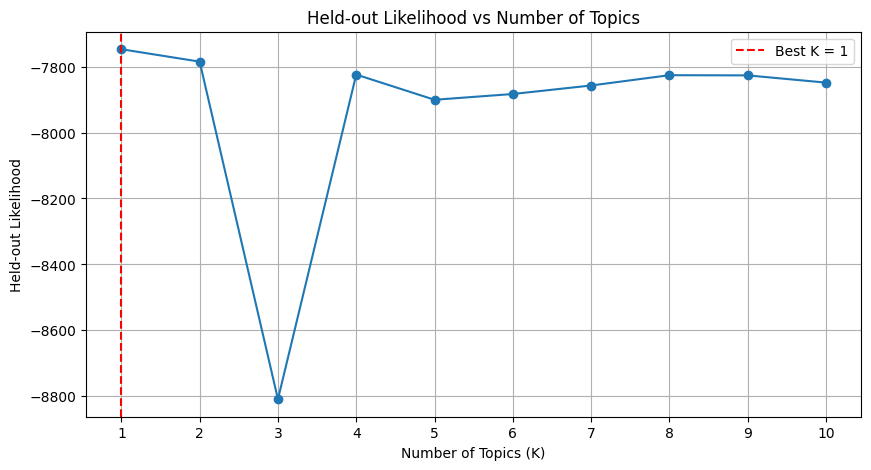

In [36]:
# Plotting
plt.figure(figsize=(10, 5))
plt.plot(range(1, 11), likelihoods, marker='o')
plt.title('Held-out Likelihood vs Number of Topics')
plt.xlabel('Number of Topics (K)')
plt.ylabel('Held-out Likelihood')
plt.xticks(range(1, 11))
plt.axvline(x=best_k, color='red', linestyle='--', label=f'Best K = {best_k}')
plt.legend()
plt.grid(True)
plt.show()


In [ ]:
#Since at K=4, we see the held-out likelihood stabilizing, we will choose it as our number of topics.
lda_instance_four_topics = LDA_CAVI(count_df, K=4)
lda_instance_four_topics.fit()

In [ ]:
#Since at K=8, we see the held-out likelihood stabilizing, we will choose it as our number of topics.
lda_instance_eight_topics = LDA_CAVI(count_df, K=8)
lda_instance_eight_topics.fit()

In [64]:
visualizer = LDA_Visualizer(lda_instance_four_topics, vectorizer.get_feature_names_out())

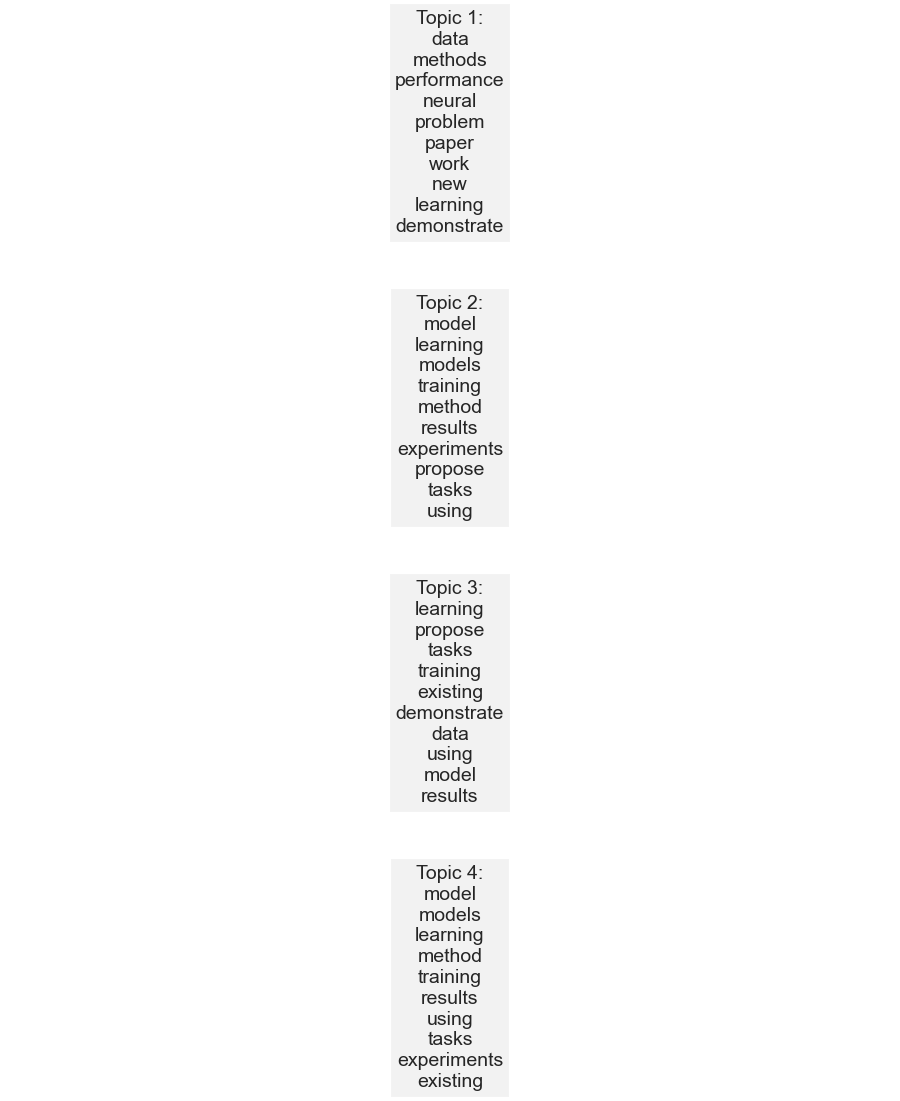

In [58]:
visualizer.plot_topics()

In [65]:

visualizer_eight = LDA_Visualizer(lda_instance_eight_topics, vectorizer.get_feature_names_out())

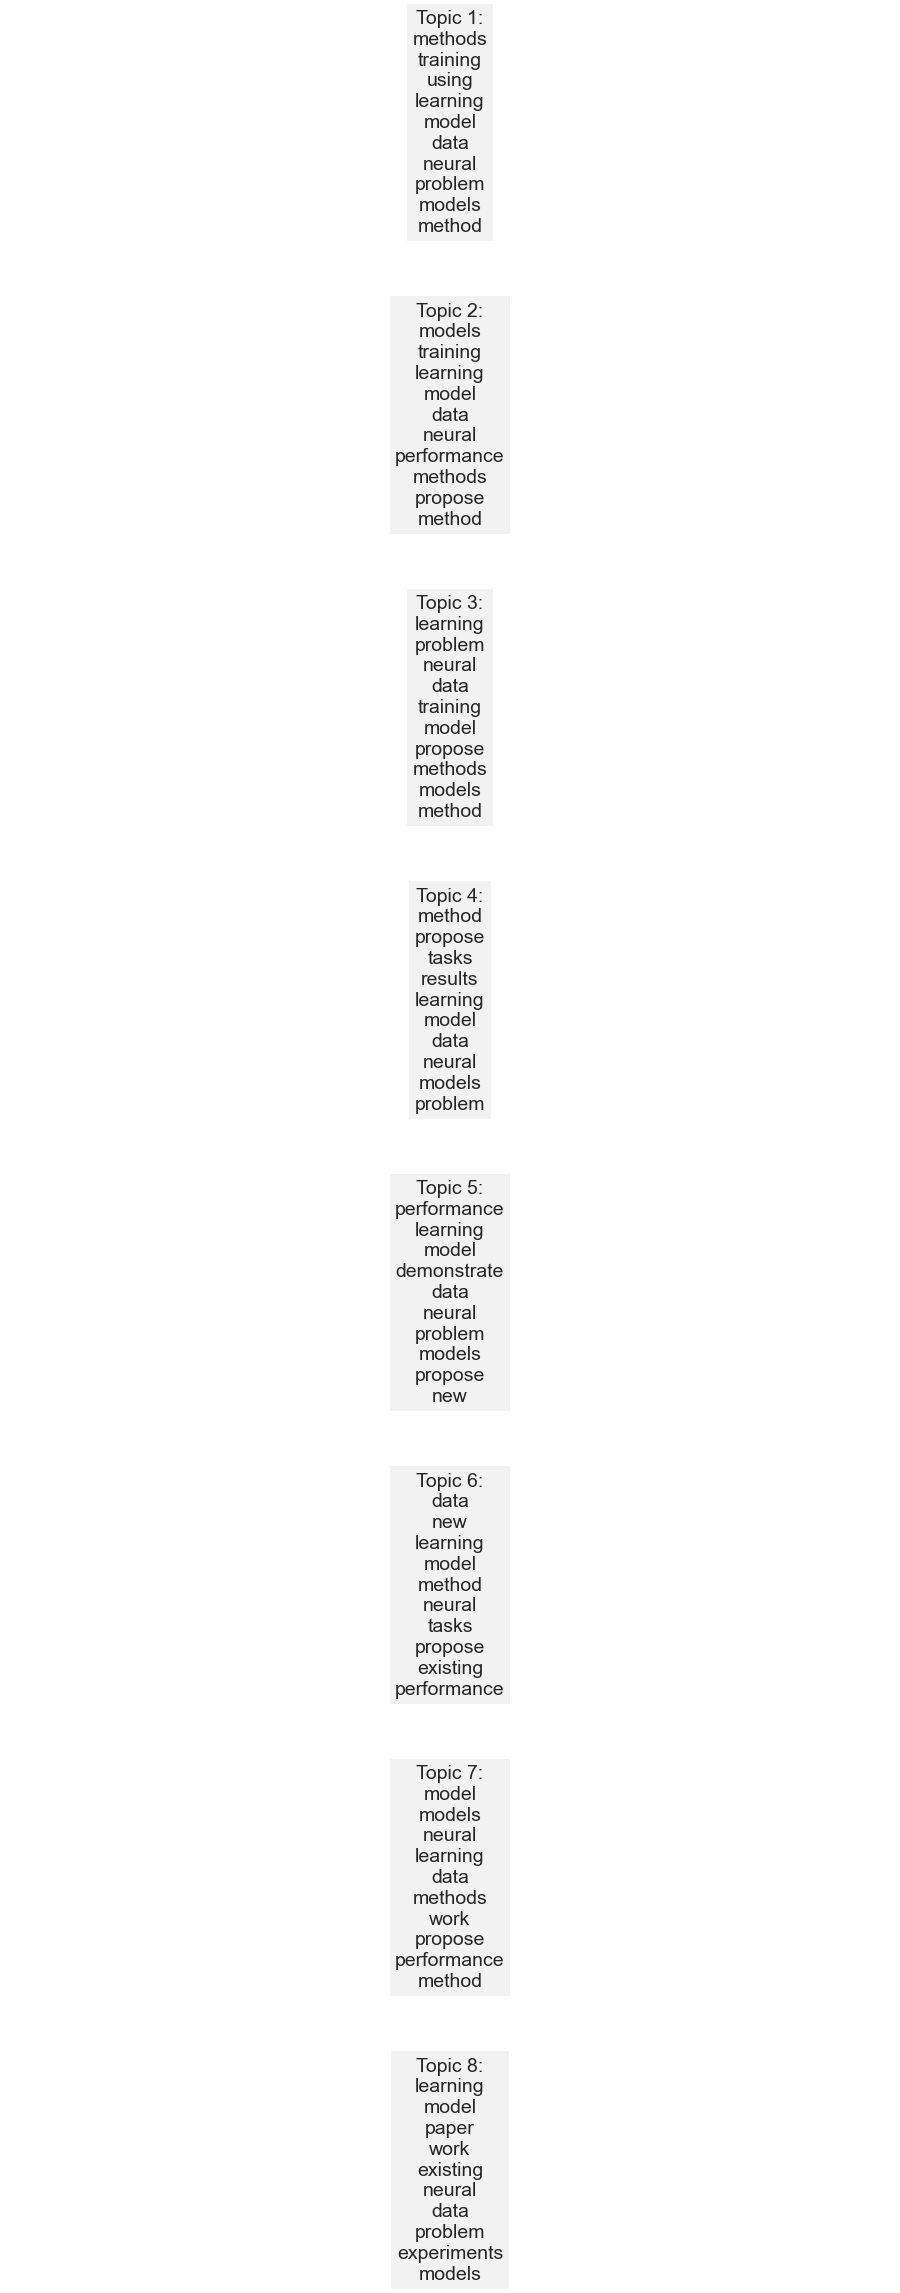

In [60]:
visualizer_eight.plot_topics()

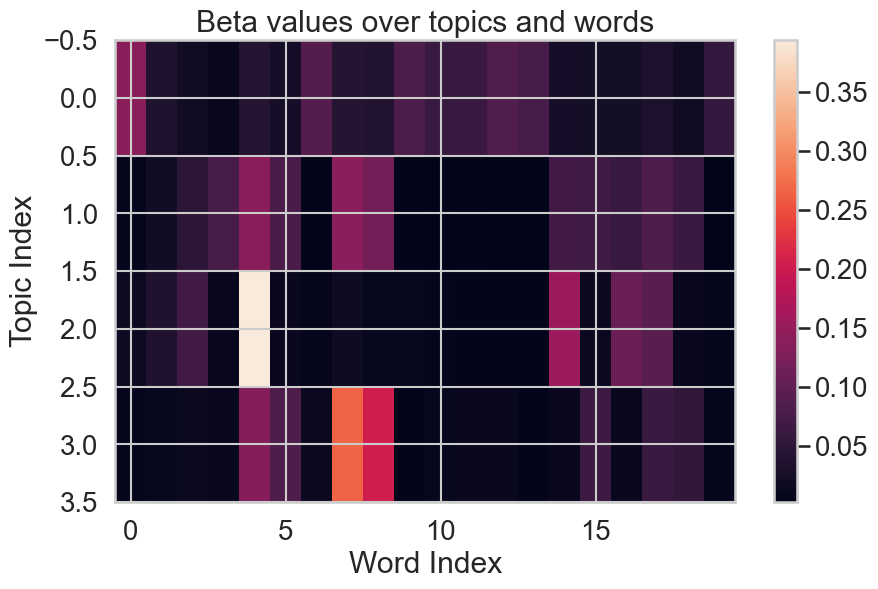

In [61]:
visualizer.plot_betas()

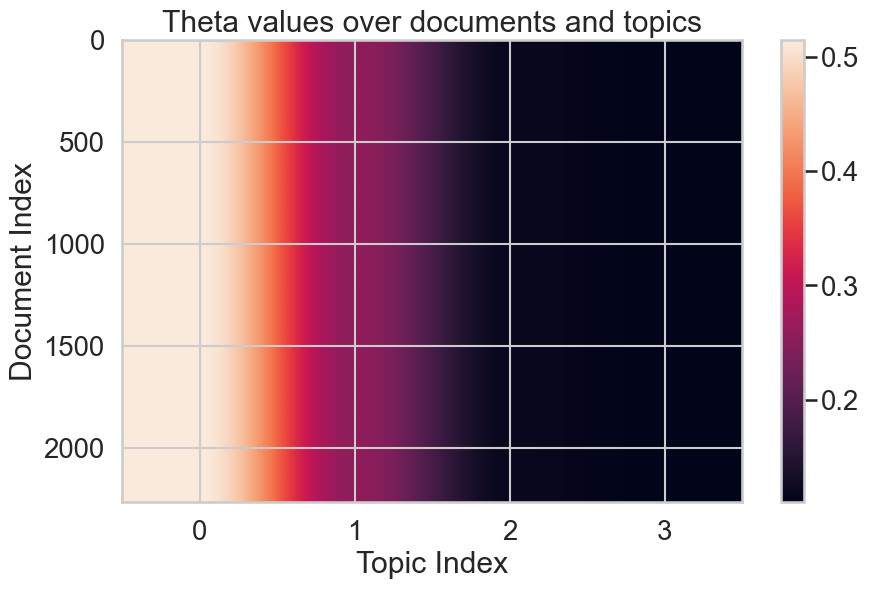

In [66]:
visualizer.plot_thetas()

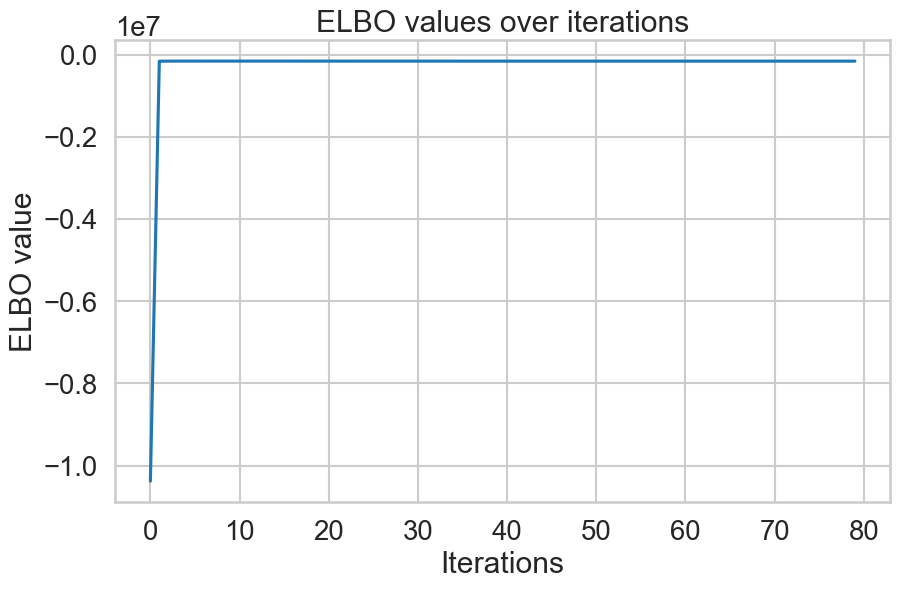

In [68]:
visualizer.plot_elbo(lda_instance_four_topics.elbo_values)

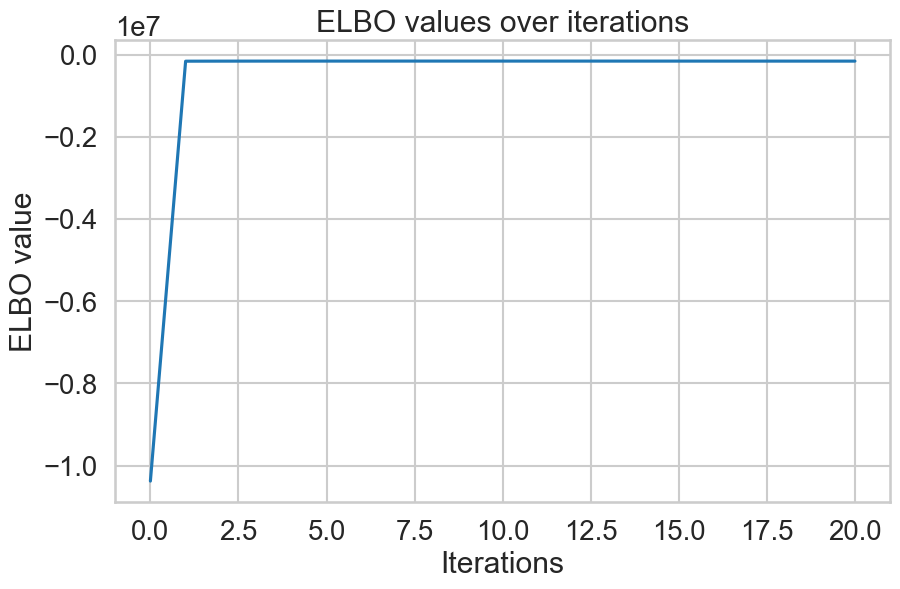

In [70]:
visualizer.plot_elbo(lda_instance_four_topics.elbo_values[:21])

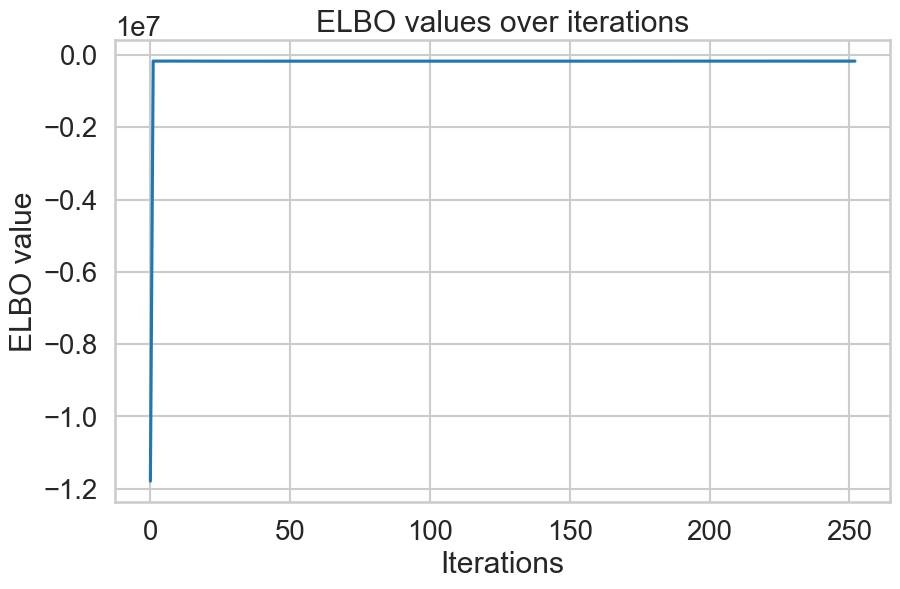

In [69]:
visualizer.plot_elbo(lda_instance_eight_topics.elbo_values)

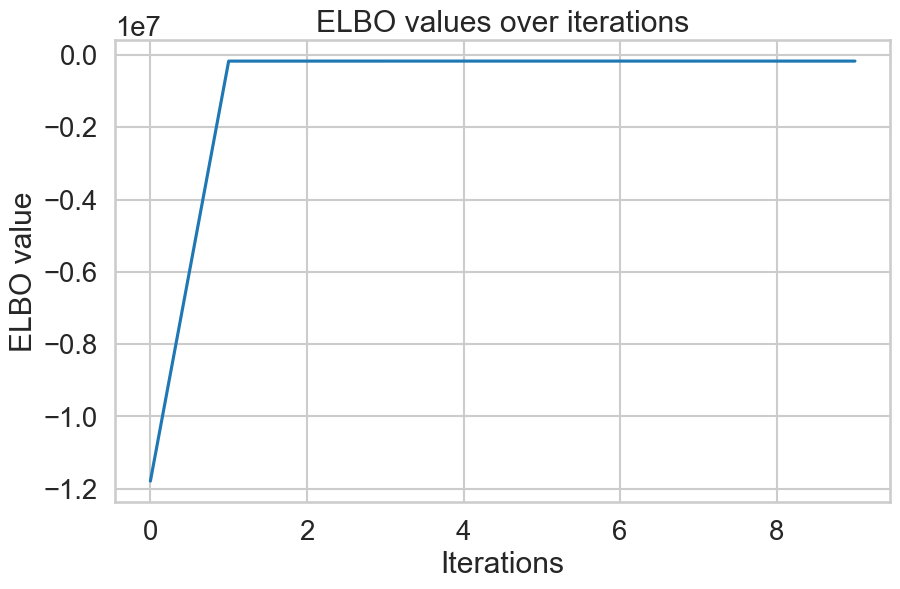

In [71]:
visualizer.plot_elbo(lda_instance_eight_topics.elbo_values[:10])

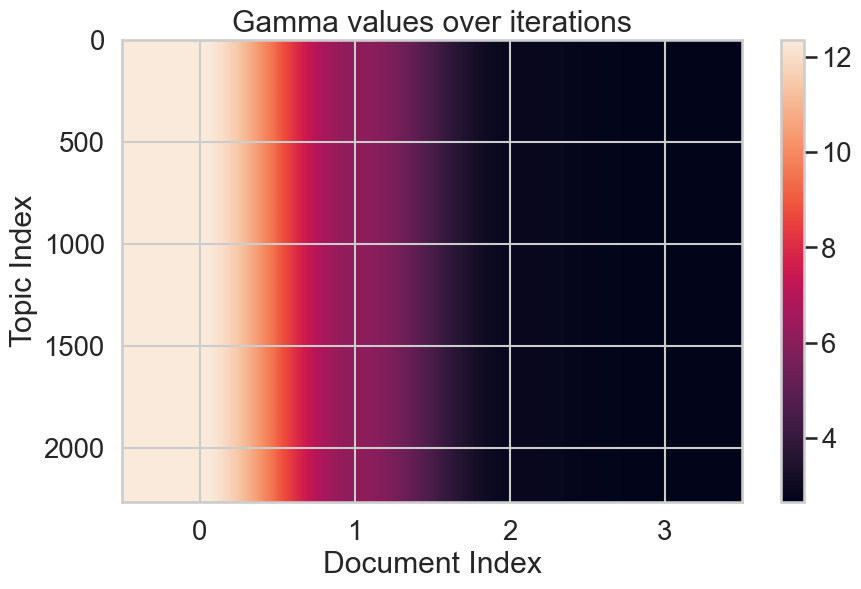

In [73]:
visualizer.plot_gammas()

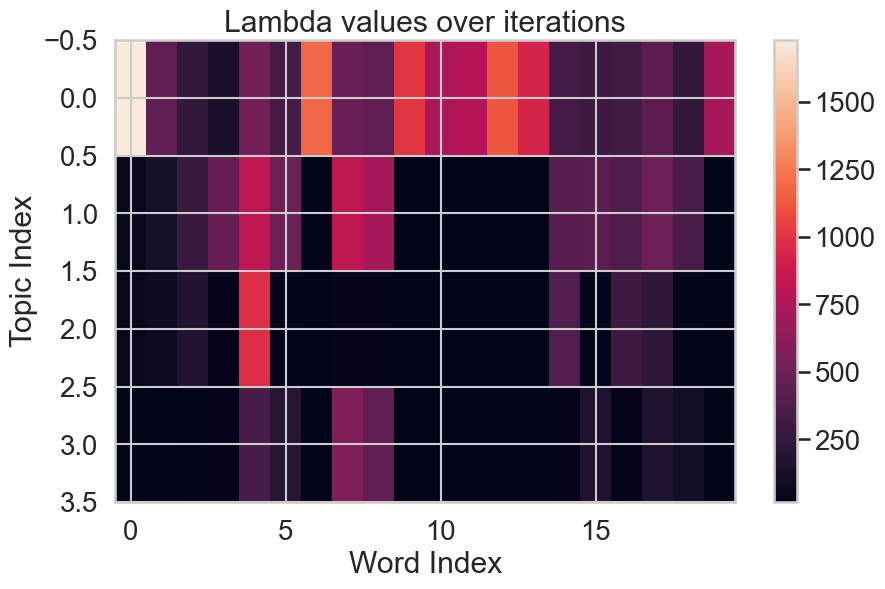

In [74]:
visualizer.plot_lambda()